In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from prettytable import PrettyTable

In [40]:
df = pd.read_csv('bike_sharing_data.csv')
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [41]:
# Convertir la columna de fecha a datetime y extraer el día del mes
# Importante: realizamos la división únicamente por día del mes como se solicitó
# Cualquier transformador futuro debe ajustarse SOLO con entrenamiento y luego aplicarse a validación/prueba

df['dteday'] = pd.to_datetime(df['dteday'])
df['day'] = df['dteday'].dt.day

train_mask = df['day'].between(1, 14)
val_mask = df['day'].between(15, 21)
test_mask = df['day'] >= 22

train_df = df.loc[train_mask].copy()
val_df = df.loc[val_mask].copy()
test_df = df.loc[test_mask].copy()


# Mostrar las primeras filas de cada partición para verificar
print('\nTrain head:')
display(train_df.head())
print('\nValidation head:')
display(val_df.head())
print('\nTest head:')
display(test_df.head())


Train head:


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,1
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,1
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,1



Validation head:


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
324,325,2011-01-15,1,0,1,0,0,6,0,1,0.18,0.2424,0.55,0.0000,3,25,28,15
325,326,2011-01-15,1,0,1,1,0,6,0,2,0.16,0.1970,0.59,0.0896,2,18,20,15
326,327,2011-01-15,1,0,1,2,0,6,0,2,0.16,0.1970,0.59,0.0896,0,12,12,15
327,328,2011-01-15,1,0,1,3,0,6,0,2,0.16,0.2273,0.59,0.0000,1,7,8,15
328,329,2011-01-15,1,0,1,4,0,6,0,2,0.16,0.2273,0.59,0.0000,0,5,5,15



Test head:


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
479,480,2011-01-22,1,0,1,0,0,6,0,1,0.04,0.0303,0.45,0.2537,0,13,13,22
480,481,2011-01-22,1,0,1,1,0,6,0,2,0.04,0.0000,0.41,0.3881,3,9,12,22
481,482,2011-01-22,1,0,1,2,0,6,0,2,0.04,0.0303,0.41,0.2537,0,11,11,22
482,483,2011-01-22,1,0,1,3,0,6,0,2,0.04,0.0303,0.41,0.2836,1,6,7,22
483,484,2011-01-22,1,0,1,4,0,6,0,2,0.02,0.0152,0.48,0.2985,0,3,3,22


In [42]:
# === Extracción de características temporales ===
# Desde 'dteday' (fecha) y 'hr' (hora), derivamos:
# - hour: hora del día (0-23)
# - dow: día de la semana (0=Lunes, 6=Domingo)
# - month: mes (1-12)
# - year: año (YYYY)
# Variables derivadas:
# - is_weekend: 1 si es sábado o domingo
# - hour_category: {madrugada (0-5), mañana (6-11), tarde (12-17), noche (18-23)}
# - is_rush_hour: 1 si es hora punta (7-9 y 17-19) EN días laborales (workingday==1)

# Categoría de hora
def _hour_bin(h):
    if 0 <= h <= 5:
        return 'madrugada'
    if 6 <= h <= 11:
        return 'mañana'
    if 12 <= h <= 17:
        return 'tarde'
    return 'noche'




df['dow'] = df['dteday'].dt.weekday
df['month'] = df['dteday'].dt.month
df['year'] = df['dteday'].dt.year


df['is_weekend'] = df['dow'].isin([5, 6]).astype(int)

df['hour_category'] = df['hr'].apply(_hour_bin)

# Hora punta (rush hour) en días laborales
df['is_rush_hour'] = (
    ((df['hr'].between(7, 9)) | (df['hr'].between(17, 19))) & (df['workingday'] == 1)
).astype(int)

cols_new = [ 'dow', 'month', 'year', 'is_weekend', 'hour_category', 'is_rush_hour']
for c in cols_new:
    train_df[c] = df.loc[train_df.index, c]
    val_df[c] = df.loc[val_df.index, c]
    test_df[c] = df.loc[test_df.index, c]


print('train_df: ')
display(train_df)
print('val_df: ')
display(val_df)
print('test_df: ')
display(test_df)

#creo que al hour_categori podriamos hacerlos numero con .encoder

train_df: 


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,casual,registered,cnt,day,dow,month,year,is_weekend,hour_category,is_rush_hour
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,3,13,16,1,5,1,2011,1,madrugada,0
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,8,32,40,1,5,1,2011,1,madrugada,0
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,5,27,32,1,5,1,2011,1,madrugada,0
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,3,10,13,1,5,1,2011,1,madrugada,0
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,0,1,1,1,5,1,2011,1,madrugada,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16968,16969,2012-12-14,4,1,12,19,0,5,1,1,...,17,302,319,14,4,12,2012,0,noche,1
16969,16970,2012-12-14,4,1,12,20,0,5,1,1,...,12,209,221,14,4,12,2012,0,noche,0
16970,16971,2012-12-14,4,1,12,21,0,5,1,1,...,7,165,172,14,4,12,2012,0,noche,0
16971,16972,2012-12-14,4,1,12,22,0,5,1,1,...,4,134,138,14,4,12,2012,0,noche,0


val_df: 


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,casual,registered,cnt,day,dow,month,year,is_weekend,hour_category,is_rush_hour
324,325,2011-01-15,1,0,1,0,0,6,0,1,...,3,25,28,15,5,1,2011,1,madrugada,0
325,326,2011-01-15,1,0,1,1,0,6,0,2,...,2,18,20,15,5,1,2011,1,madrugada,0
326,327,2011-01-15,1,0,1,2,0,6,0,2,...,0,12,12,15,5,1,2011,1,madrugada,0
327,328,2011-01-15,1,0,1,3,0,6,0,2,...,1,7,8,15,5,1,2011,1,madrugada,0
328,329,2011-01-15,1,0,1,4,0,6,0,2,...,0,5,5,15,5,1,2011,1,madrugada,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17136,17137,2012-12-21,1,1,12,19,0,5,1,1,...,5,148,153,21,4,12,2012,0,noche,1
17137,17138,2012-12-21,1,1,12,20,0,5,1,1,...,8,104,112,21,4,12,2012,0,noche,0
17138,17139,2012-12-21,1,1,12,21,0,5,1,1,...,2,68,70,21,4,12,2012,0,noche,0
17139,17140,2012-12-21,1,1,12,22,0,5,1,1,...,6,57,63,21,4,12,2012,0,noche,0


test_df: 


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,casual,registered,cnt,day,dow,month,year,is_weekend,hour_category,is_rush_hour
479,480,2011-01-22,1,0,1,0,0,6,0,1,...,0,13,13,22,5,1,2011,1,madrugada,0
480,481,2011-01-22,1,0,1,1,0,6,0,2,...,3,9,12,22,5,1,2011,1,madrugada,0
481,482,2011-01-22,1,0,1,2,0,6,0,2,...,0,11,11,22,5,1,2011,1,madrugada,0
482,483,2011-01-22,1,0,1,3,0,6,0,2,...,1,6,7,22,5,1,2011,1,madrugada,0
483,484,2011-01-22,1,0,1,4,0,6,0,2,...,0,3,3,22,5,1,2011,1,madrugada,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,...,11,108,119,31,0,12,2012,0,noche,1
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,...,8,81,89,31,0,12,2012,0,noche,0
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,...,7,83,90,31,0,12,2012,0,noche,0
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,...,13,48,61,31,0,12,2012,0,noche,0


# Análisis exploratorio (EDA)

- Estadísticas descriptivas de todas las variables.
- Matriz de correlación con heatmap.
- Distribución de `cnt` y de `log(cnt + 1)` para evaluar una posible transformación.
- Visualizaciones:
  - Demanda promedio por hora del día.
  - Demanda promedio por día de la semana.
  - Relación entre temperatura y demanda.
  - Boxplots de demanda por condición climática.


Estadísticas descriptivas (numéricas):


,count,mean,min,25%,50%,75%,max,std
instant,17379.0,8690.0,1.0,4345.5,8690.0,13034.5,17379.0,5017.0295
dteday,17379,2012-01-02 04:08:34.552045568,2011-01-01 00:00:00,2011-07-04 00:00:00,2012-01-02 00:00:00,2012-07-02 00:00:00,2012-12-31 00:00:00,NaN
season,17379.0,2.50164,1.0,2.0,3.0,3.0,4.0,1.106918
yr,17379.0,0.502561,0.0,0.0,1.0,1.0,1.0,0.500008
mnth,17379.0,6.537775,1.0,4.0,7.0,10.0,12.0,3.438776
hr,17379.0,11.546752,0.0,6.0,12.0,18.0,23.0,6.914405
holiday,17379.0,0.02877,0.0,0.0,0.0,0.0,1.0,0.167165
weekday,17379.0,3.003683,0.0,1.0,3.0,5.0,6.0,2.005771
workingday,17379.0,0.682721,0.0,0.0,1.0,1.0,1.0,0.465431
weathersit,17379.0,1.425283,1.0,1.0,1.0,2.0,4.0,0.639357



Estadísticas descriptivas (incluyendo categóricas):


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
instant,17379.0,NaN,NaN,NaN,8690.0,1.0,4345.5,8690.0,13034.5,17379.0,5017.0295
dteday,17379,NaN,NaN,NaN,2012-01-02 04:08:34.552045568,2011-01-01 00:00:00,2011-07-04 00:00:00,2012-01-02 00:00:00,2012-07-02 00:00:00,2012-12-31 00:00:00,NaN
season,17379.0,NaN,NaN,NaN,2.50164,1.0,2.0,3.0,3.0,4.0,1.106918
yr,17379.0,NaN,NaN,NaN,0.502561,0.0,0.0,1.0,1.0,1.0,0.500008
mnth,17379.0,NaN,NaN,NaN,6.537775,1.0,4.0,7.0,10.0,12.0,3.438776
hr,17379.0,NaN,NaN,NaN,11.546752,0.0,6.0,12.0,18.0,23.0,6.914405
holiday,17379.0,NaN,NaN,NaN,0.02877,0.0,0.0,0.0,0.0,1.0,0.167165
weekday,17379.0,NaN,NaN,NaN,3.003683,0.0,1.0,3.0,5.0,6.0,2.005771
workingday,17379.0,NaN,NaN,NaN,0.682721,0.0,0.0,1.0,1.0,1.0,0.465431
weathersit,17379.0,NaN,NaN,NaN,1.425283,1.0,1.0,1.0,2.0,4.0,0.639357


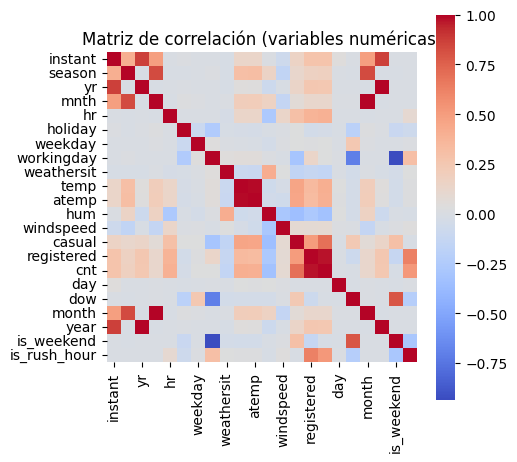

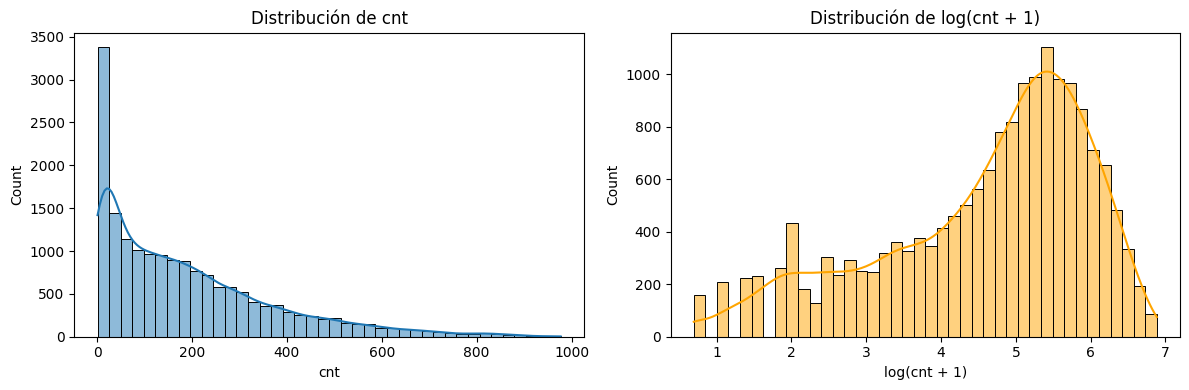

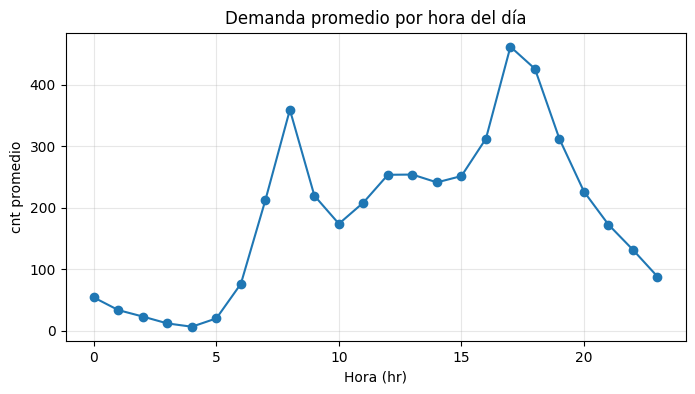

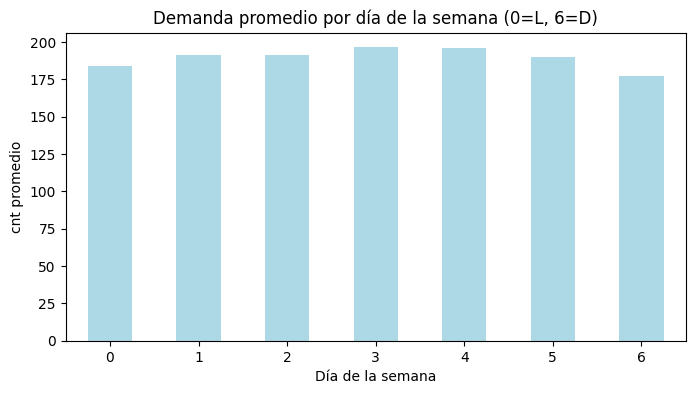

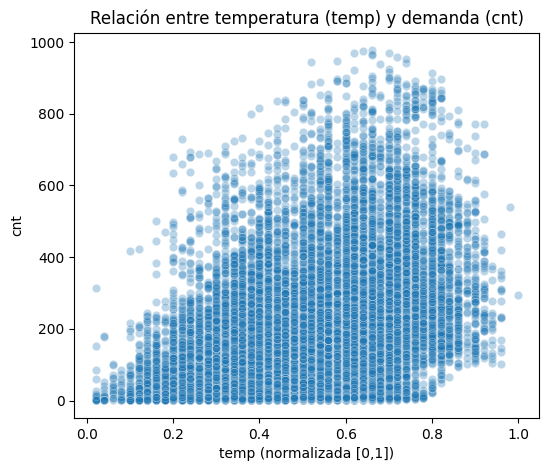

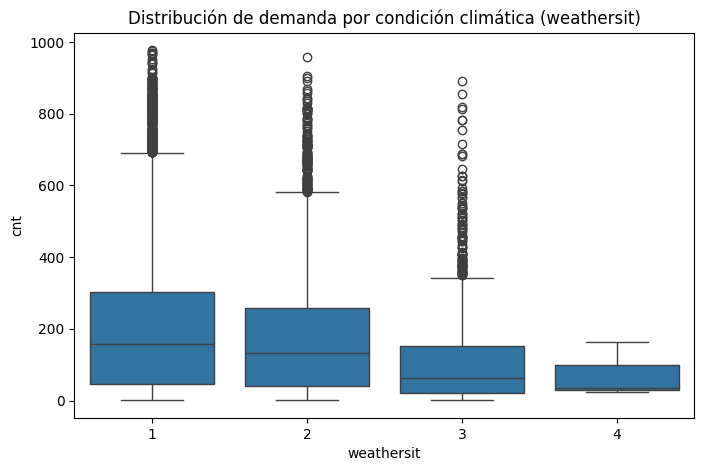

In [43]:

eda_df = df.copy()

# 1) Estadísticas descriptivas
print('Estadísticas descriptivas (numéricas):')
display(eda_df.describe().T)

print('\nEstadísticas descriptivas (incluyendo categóricas):')
display(eda_df.describe(include='all').T)

# 2) Matriz de correlación y heatmap (solo numéricas)
num_cols = [c for c in eda_df.columns if pd.api.types.is_numeric_dtype(eda_df[c])]
corr = eda_df[num_cols].corr()
plt.figure(figsize=(5, 5))
sns.heatmap(corr, cmap='coolwarm', annot=False, square=True)
plt.title('Matriz de correlación (variables numéricas)')
plt.show()

# 3) Distribución de cnt y log(cnt+1)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(eda_df['cnt'], bins=40, kde=True, ax=axes[0])
axes[0].set_title('Distribución de cnt')
axes[0].set_xlabel('cnt')

eda_df['log_cnt'] = np.log1p(eda_df['cnt'])
sns.histplot(eda_df['log_cnt'], bins=40, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Distribución de log(cnt + 1)')
axes[1].set_xlabel('log(cnt + 1)')
plt.tight_layout()
plt.show()

# 4) Visualizaciones 
# a) Demanda promedio por hora del día
plt.figure(figsize=(8,4))
(eda_df.groupby('hr')['cnt'].mean()).plot(kind='line', marker='o')
plt.title('Demanda promedio por hora del día')
plt.xlabel('Hora (hr)')
plt.ylabel('cnt promedio')
plt.grid(True, alpha=0.3)
plt.show()

# b) Demanda promedio por dia de la semana (dow)
plt.figure(figsize=(8,4))
(eda_df.groupby('dow')['cnt'].mean()).plot(kind='bar', color='lightblue')
plt.title('Demanda promedio por día de la semana (0=L, 6=D)')
plt.xlabel('Día de la semana')
plt.ylabel('cnt promedio')
plt.xticks(rotation=0)
plt.show()

# c) Relación entre temperatura y demanda
plt.figure(figsize=(6,5))
sns.scatterplot(data=eda_df, x='temp', y='cnt', alpha=0.3)
plt.title('Relación entre temperatura (temp) y demanda (cnt)')
plt.xlabel('temp (normalizada [0,1])')
plt.ylabel('cnt')
plt.show()

# d) Boxplots de demanda por condición climática
# En este dataset 'weathersit' codifica el clima (1=despejado, 2=nubes, 3=lluvia ligera, 4=lluvia fuerte)
plt.figure(figsize=(8,5))
sns.boxplot(data=eda_df, x='weathersit', y='cnt')
plt.title('Distribución de demanda por condición climática (weathersit)')
plt.xlabel('weathersit')
plt.ylabel('cnt')
plt.show()



# d) Preparación de datos
Objetivos:
- Identificar y documentar valores faltantes o anómalos.
- Crear variable objetivo transformada: cnt_log = log1p(cnt).
- Normalizar variables numéricas (ajustar SOLO con train y aplicar a val/test).

In [44]:
#viendolo a la rapida se ve mucho gpt y no me convence la vd, nose si este bueno

# --- 1) Reporte de faltantes y valores potencialmente anómalos ---
def report_missing_and_anomalies(df_in, name):
    print(f"\n=== {name}: valores faltantes ===")
    miss = df_in.isna().sum()
    if miss.sum() > 0:
        display(miss[miss > 0].sort_values(ascending=False))
    else:
        print("Sin valores faltantes detectados.")

    # Duplicados (fila completa idéntica)
    dups = int(df_in.duplicated().sum())
    print(f"Duplicados (filas): {dups}")

    # Chequeos simples de rango/categorías (solo se evalúan si la columna existe)
    checks = {
        'hr': lambda s: ~s.between(0, 23),
        'temp': lambda s: ~s.between(0, 1),
        'atemp': lambda s: ~s.between(0, 1),
        'hum': lambda s: ~s.between(0, 1),
        'windspeed': lambda s: ~s.between(0, 1),
        'weathersit': lambda s: ~s.isin([1, 2, 3, 4]),
        'season': lambda s: ~s.isin([1, 2, 3, 4]),
        'mnth': lambda s: ~s.between(1, 12),
        'dow': lambda s: ~s.between(0, 6),
        'weekday': lambda s: ~s.between(0, 6),
        'workingday': lambda s: ~s.isin([0, 1]),
        'holiday': lambda s: ~s.isin([0, 1]),
        'cnt': lambda s: s < 0,
        'casual': lambda s: s < 0,
        'registered': lambda s: s < 0,
    }
    anomalies_counts = {}
    for col, cond in checks.items():
        if col in df_in.columns:
            try:
                anomalies_counts[col] = int(cond(df_in[col]).sum())
            except Exception:
                # Por si la columna no es del tipo esperado
                pass
    if anomalies_counts:
        print("Posibles valores anómalos (conteos por columna):")
        display(pd.Series(anomalies_counts).sort_index())
    else:
        print("No se evaluaron anomalías por ausencia de columnas relevantes.")


report_missing_and_anomalies(train_df, 'Train')
report_missing_and_anomalies(val_df, 'Validación')
report_missing_and_anomalies(test_df, 'Prueba')

# --- 2) Variable objetivo transformada ---
for split in (train_df, val_df, test_df):
    split['cnt_log'] = np.log1p(split['cnt'])


# --- 3) Normalización de variables numéricas  ---
num_cols = [c for c in train_df.columns if pd.api.types.is_numeric_dtype(train_df[c])]
cols_to_exclude = [c for c in ['cnt', 'casual', 'registered', 'day'] if c in num_cols]
num_features = [c for c in num_cols if c not in cols_to_exclude]


# Escalado estándar (ajustar en train y pasar a val/test)
scaler = StandardScaler()
scaler.fit(train_df[num_features])

train_scaled = scaler.transform(train_df[num_features])
val_scaled = scaler.transform(val_df[num_features])
test_scaled = scaler.transform(test_df[num_features])

scaled_cols = [f"{c}_sc" for c in num_features]
train_df.loc[:, scaled_cols] = train_scaled
val_df.loc[:, scaled_cols] = val_scaled
test_df.loc[:, scaled_cols] = test_scaled

display(train_df)
display(val_df)
display(test_df)



=== Train: valores faltantes ===
Sin valores faltantes detectados.
Duplicados (filas): 0
Posibles valores anómalos (conteos por columna):


atemp         0
casual        0
cnt           0
dow           0
holiday       0
hr            0
hum           0
mnth          0
registered    0
season        0
temp          0
weathersit    0
weekday       0
windspeed     0
workingday    0
dtype: int64


=== Validación: valores faltantes ===
Sin valores faltantes detectados.
Duplicados (filas): 0
Posibles valores anómalos (conteos por columna):


atemp         0
casual        0
cnt           0
dow           0
holiday       0
hr            0
hum           0
mnth          0
registered    0
season        0
temp          0
weathersit    0
weekday       0
windspeed     0
workingday    0
dtype: int64


=== Prueba: valores faltantes ===
Sin valores faltantes detectados.
Duplicados (filas): 0
Posibles valores anómalos (conteos por columna):


atemp         0
casual        0
cnt           0
dow           0
holiday       0
hr            0
hum           0
mnth          0
registered    0
season        0
temp          0
weathersit    0
weekday       0
windspeed     0
workingday    0
dtype: int64

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,temp_sc,atemp_sc,hum_sc,windspeed_sc,dow_sc,month_sc,year_sc,is_weekend_sc,is_rush_hour_sc,cnt_log_sc
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,-1.270476,-1.042009,0.984349,-1.543684,0.998708,-1.600950,-1.002995,1.578317,-0.456875,-1.219886
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,-1.372131,-1.128758,0.933451,-1.543684,0.998708,-1.600950,-1.002995,1.578317,-0.456875,-0.603223
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,-1.372131,-1.128758,0.933451,-1.543684,0.998708,-1.600950,-1.002995,1.578317,-0.456875,-0.755270
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,-1.270476,-1.042009,0.678959,-1.543684,0.998708,-1.600950,-1.002995,1.578317,-0.456875,-1.355886
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,-1.270476,-1.042009,0.678959,-1.543684,0.998708,-1.600950,-1.002995,1.578317,-0.456875,-2.718933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16968,16969,2012-12-14,4,1,12,19,0,5,1,1,...,-0.762199,-0.696151,-0.440804,-0.814176,0.498638,1.590756,0.997014,-0.633586,2.188782,0.836062
16969,16970,2012-12-14,4,1,12,20,0,5,1,1,...,-0.863855,-0.782901,-0.033617,-0.450236,0.498638,1.590756,0.997014,-0.633586,-0.456875,0.579940
16970,16971,2012-12-14,4,1,12,21,0,5,1,1,...,-0.965510,-0.955829,0.678959,-0.206795,0.498638,1.590756,0.997014,-0.633586,-0.456875,0.405254
16971,16972,2012-12-14,4,1,12,22,0,5,1,1,...,-1.067165,-1.042009,0.678959,-0.692863,0.498638,1.590756,0.997014,-0.633586,-0.456875,0.251979


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,temp_sc,atemp_sc,hum_sc,windspeed_sc,dow_sc,month_sc,year_sc,is_weekend_sc,is_rush_hour_sc,cnt_log_sc
324,325,2011-01-15,1,0,1,0,0,6,0,1,...,-1.575442,-1.301687,-0.339007,-1.543684,0.998708,-1.600950,-1.002995,1.578317,-0.456875,-0.845779
325,326,2011-01-15,1,0,1,1,0,6,0,2,...,-1.677097,-1.560795,-0.135414,-0.814176,0.998708,-1.600950,-1.002995,1.578317,-0.456875,-1.071871
326,327,2011-01-15,1,0,1,2,0,6,0,2,...,-1.677097,-1.560795,-0.135414,-0.814176,0.998708,-1.600950,-1.002995,1.578317,-0.456875,-1.407796
327,328,2011-01-15,1,0,1,3,0,6,0,2,...,-1.677097,-1.387866,-0.135414,-1.543684,0.998708,-1.600950,-1.002995,1.578317,-0.456875,-1.665376
328,329,2011-01-15,1,0,1,4,0,6,0,2,...,-1.677097,-1.387866,-0.135414,-1.543684,0.998708,-1.600950,-1.002995,1.578317,-0.456875,-1.949391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17136,17137,2012-12-21,1,1,12,19,0,5,1,1,...,-1.067165,-1.214937,-0.847990,0.886653,0.498638,1.590756,0.997014,-0.633586,2.188782,0.323762
17137,17138,2012-12-21,1,1,12,20,0,5,1,1,...,-1.067165,-1.128758,-1.051584,0.521899,0.498638,1.590756,0.997014,-0.633586,-0.456875,0.106922
17138,17139,2012-12-21,1,1,12,21,0,5,1,1,...,-1.168821,-1.387866,-1.051584,1.858787,0.498638,1.590756,0.997014,-0.633586,-0.456875,-0.218591
17139,17140,2012-12-21,1,1,12,22,0,5,1,1,...,-1.168821,-1.387866,-0.898889,0.886653,0.498638,1.590756,0.997014,-0.633586,-0.456875,-0.291297


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,temp_sc,atemp_sc,hum_sc,windspeed_sc,dow_sc,month_sc,year_sc,is_weekend_sc,is_rush_hour_sc,cnt_log_sc
479,480,2011-01-22,1,0,1,0,0,6,0,1,...,-2.287029,-2.512190,-0.847990,0.521899,0.998708,-1.600950,-1.002995,1.578317,-0.456875,-1.355886
480,481,2011-01-22,1,0,1,1,0,6,0,2,...,-2.287029,-2.685118,-1.051584,1.616161,0.998708,-1.600950,-1.002995,1.578317,-0.456875,-1.407796
481,482,2011-01-22,1,0,1,2,0,6,0,2,...,-2.287029,-2.512190,-1.051584,0.521899,0.998708,-1.600950,-1.002995,1.578317,-0.456875,-1.463864
482,483,2011-01-22,1,0,1,3,0,6,0,2,...,-2.287029,-2.512190,-1.051584,0.765339,0.998708,-1.600950,-1.002995,1.578317,-0.456875,-1.747879
483,484,2011-01-22,1,0,1,4,0,6,0,2,...,-2.388684,-2.598369,-0.695295,0.886653,0.998708,-1.600950,-1.002995,1.578317,-0.456875,-2.233406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,...,-1.168821,-1.214937,-0.084516,-0.206795,-1.501645,1.590756,0.997014,-0.633586,2.188782,0.149023
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,...,-1.168821,-1.214937,-0.084516,-0.206795,-1.501645,1.590756,0.997014,-0.633586,-0.456875,-0.052489
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,...,-1.168821,-1.214937,-0.084516,-0.206795,-1.501645,1.590756,0.997014,-0.633586,-0.456875,-0.044749
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,...,-1.168821,-1.128758,-0.288109,-0.450236,-1.501645,1.590756,0.997014,-0.633586,-0.456875,-0.313536


## 2.a

In [49]:
cols =['season', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']

df_original = df.loc[:,cols].copy()
#df_original = df.copy()

x = df_original.copy() 
y = df['cnt'].copy()
#x = df_original.drop(columns=['cnt'])
#y = df_original['cnt']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=254)#random_state = 42 o 254

In [50]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'R2: {r2}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


MSE: 22970.004079963957
R2: 0.2779522721458857
RMSE: 151.558582996688
MAE: 114.46877815222562


Valores iniciales de ridge:
MSE: 22970.58447972613
R2: 0.27793402764196373
Alpha optimo: 1
Valores optimizados de ridge:
MSE: 22970.58447972613
R2: 0.27793402764196373


C:\Users\nicon\AppData\Local\Temp\ipykernel_15900\1868588138.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_ridge = pd.concat([df_ridge, pd.DataFrame([[i, mse_ridge, r2_ridge]], columns=cols_ridge)], ignore_index=True)


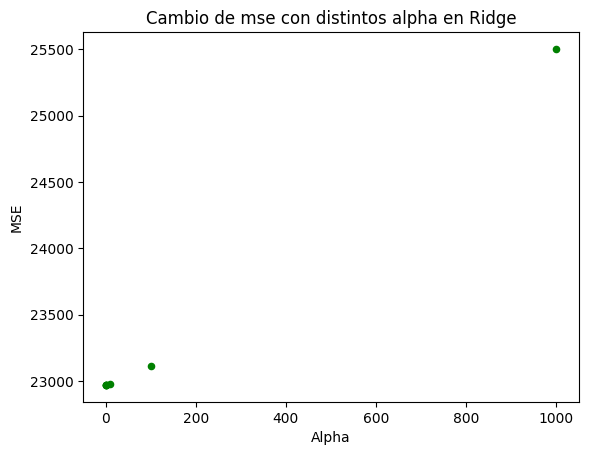

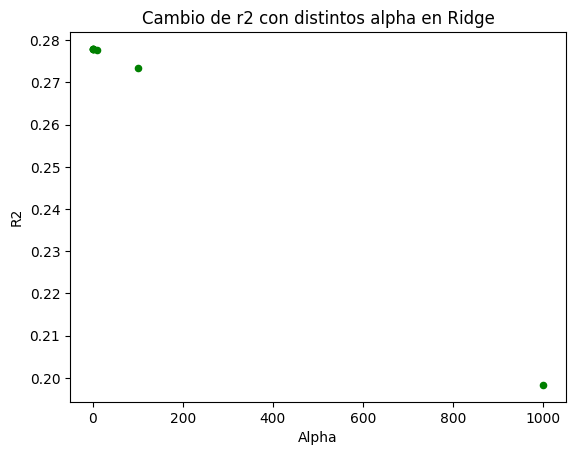

In [51]:
#3.a
l1 = Ridge()
l1.fit(x_train, y_train)
y_pred_l1 = l1.predict(x_test)
print('Valores iniciales de ridge:')
print(f'MSE: {mean_squared_error(y_test, y_pred_l1)}')
print(f'R2: {r2_score(y_test, y_pred_l1)}')

l1_optimizer = GridSearchCV(l1, {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, cv=5, scoring='r2')
l1_optimizer.fit(x_train, y_train)

print(f'Alpha optimo: {l1_optimizer.best_params_['alpha']}')

l1_opt = Ridge(l1_optimizer.best_params_['alpha'])
l1_opt.fit(x_train, y_train)
y_pred_l1 = l1_opt.predict(x_test)
mse_optimizado_l1 = mean_squared_error(y_test, y_pred_l1)
r2_optimizado_l1 = r2_score(y_test, y_pred_l1)
print('Valores optimizados de ridge:')
print(f'MSE: {mse_optimizado_l1}')
print(f'R2: {r2_optimizado_l1}')

lista_alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cols_ridge = ['alpha', 'mse', 'r2']
df_ridge = pd.DataFrame(columns=cols_ridge)
for i in lista_alpha:
    l1 = Ridge(i)
    l1.fit(x_train, y_train)
    y_pred_l1 = l1.predict(x_test)
    mse_ridge = mean_squared_error(y_test, y_pred_l1)
    r2_ridge = r2_score(y_test, y_pred_l1)
    df_ridge = pd.concat([df_ridge, pd.DataFrame([[i, mse_ridge, r2_ridge]], columns=cols_ridge)], ignore_index=True)
df_ridge

df_ridge.plot(kind='scatter', x='alpha', y='mse', color='green')
plt.title('Cambio de mse con distintos alpha en Ridge')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.show()
df_ridge.plot(kind='scatter', x='alpha', y='r2', color='green')
plt.title('Cambio de r2 con distintos alpha en Ridge')
plt.xlabel('Alpha')
plt.ylabel('R2')
plt.show()

In [ ]:
#3.b
l2 = Lasso()
l2.fit(x_train, y_train)
y_pred_l2 = l2.predict(x_test)
print('Valores iniciales de lasso:')
print(f'MSE: {mean_squared_error(y_test, y_pred_l2)}')
print(f'R2: {r2_score(y_test, y_pred_l2)}')

l2_optimizer = GridSearchCV(l2, {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, cv=5, scoring='r2')
l2_optimizer.fit(x_train, y_train)

print(f'Alpha optimo: {l2_optimizer.best_params_['alpha']}')

l2_opt = Ridge(l2_optimizer.best_params_['alpha'])
l2_opt.fit(x_train, y_train)
y_pred_l2 = l2_opt.predict(x_test)
mse_optimizado_l2 = mean_squared_error(y_test, y_pred_l2)
r2_optimizado_l2 = r2_score(y_test, y_pred_l2)
print('Valores optimizados de lasso:')
print(f'MSE: {mse_optimizado_l2}')
print(f'R2: {r2_optimizado_l2}')

ec = ''
for coeficiente, predictor in zip(l2_opt.coef_, x.columns):
    ec += f' {abs(coeficiente):.3f}*{predictor} +'
modelo_ajustado_l2 = f'l2_y_hat = {l2_opt.intercept_:.3f} +{ec}'
modelo_ajustado_l2

table = PrettyTable()
table.field_names = ["Modelo", "MSE", "R2"]
table.add_row(["Sin regulador", mse, r2])
table.add_row(["Ridge", mse_optimizado_l1, r2_optimizado_l1])
table.add_row(["Lasso", mse_optimizado_l2, r2_optimizado_l2])
table

Valores iniciales de lasso:
MSE: 23123.746292985237
R2: 0.2731194817292697
Alpha optimo: 0.01
Valores optimizados de lasso:
MSE: 22970.00883135684
R2: 0.27795212278881876


Modelo,MSE,R2
Sin regulador,22970.004079963957,0.2779522721458857
Ridge,22970.58447972613,0.27793402764196373
Lasso,22970.00883135684,0.27795212278881876
